# Snake

In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
from environments_fully_observable import OriginalSnakeEnvironment
import numpy as np
from  tqdm import trange
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from agents import BaselineAgent, RandomAgent, DQNAgent
tf.random.set_seed(0)
random.seed(0)
np.random.seed(0)

## Environment definition

In [3]:
def plot_board(boards, how_many=5):
    num_boards = min(len(boards), how_many)
    
    # If only one board is passed, axs should not be an array
    if num_boards == 1:
        fig, ax = plt.subplots(1, 1, figsize=(10, 3))
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.imshow(boards[0], origin="lower")
    else:
        fig, axs = plt.subplots(1, num_boards, figsize=(10, 3))
        for ax, board in zip(axs, boards[:num_boards]):
            ax.get_yaxis().set_visible(False)
            ax.get_xaxis().set_visible(False)
            ax.imshow(board, origin="lower")

    plt.show()


## Baseline vs Random

In [4]:
MOVES_PER_GAME = 1000 
NUM_BOARDS = 10 # Change to 1000
BOARD_SIZE = 7
ITERS = 100

In [19]:
tf.keras.utils.disable_interactive_logging()

# Initialize lists to store average rewards
rnd_avg_rewards = []
baseline_avg_rewards = []
dqn_avg_rewards = []

rnd_env = OriginalSnakeEnvironment(NUM_BOARDS, BOARD_SIZE)
base_env = OriginalSnakeEnvironment(NUM_BOARDS, BOARD_SIZE)
dqn_env = OriginalSnakeEnvironment(NUM_BOARDS, BOARD_SIZE)

rnd_agent = RandomAgent(rnd_env.boards) # Random agent does not need the board
baseline_agent = BaselineAgent(base_env.boards) 
dqn_agent = DQNAgent(dqn_env.boards)

for iter in trange(ITERS):
    rnd_env = OriginalSnakeEnvironment(NUM_BOARDS, BOARD_SIZE)
    base_env = OriginalSnakeEnvironment(NUM_BOARDS, BOARD_SIZE)
    dqn_env = OriginalSnakeEnvironment(NUM_BOARDS, BOARD_SIZE)

    # Updating the agents' environments
    rnd_agent.boards = rnd_env.boards
    baseline_agent.boards = base_env.boards
    dqn_agent.boards = dqn_env.boards

    rnd_rewards = []
    baseline_rewards = []
    dqn_rewards = []
    
    for _ in range(MOVES_PER_GAME):
        # Get actions from the agents
        rnd_actions = rnd_agent.get_actions()
        base_actions = baseline_agent.get_actions()
        dqn_actions = dqn_agent.get_actions()

        prev_boards = dqn_env.boards.copy() # saving for the dqn
        
        # Perform the actions and get the rewards from the environment
        rnd_reward = rnd_env.move(rnd_actions)
        baseline_reward = base_env.move(base_actions)
        dqn_reward = dqn_env.move(dqn_actions)

        # Make the agent learn
        dqn_agent.learn(prev_boards, dqn_actions, dqn_reward, dqn_env.boards)
        
        # Store the rewards for each move
        rnd_rewards.append(rnd_reward)
        baseline_rewards.append(baseline_reward)
        dqn_rewards.append(dqn_reward)
    
    # Compute the average reward for this iteration
    rnd_avg_rewards.append(np.mean(rnd_rewards))
    baseline_avg_rewards.append(np.mean(baseline_rewards))
    dqn_avg_rewards.append(np.mean(dqn_rewards))

# After the training loop, you can plot or analyze the average rewards
print(f"Random Agent Average Rewards over {ITERS} iterations: {np.mean(rnd_avg_rewards)}")
print(f"Baseline Agent Average Rewards over {ITERS} iterations: {np.mean(baseline_avg_rewards)}")
print(f"DQN Agent Average Rewards over {ITERS} iterations: {np.mean(dqn_avg_rewards)}")

100%|██████████| 10/10 [01:05<00:00,  6.60s/it]

DQN Agent Average Rewards over 100 iterations: -0.03529999777674675


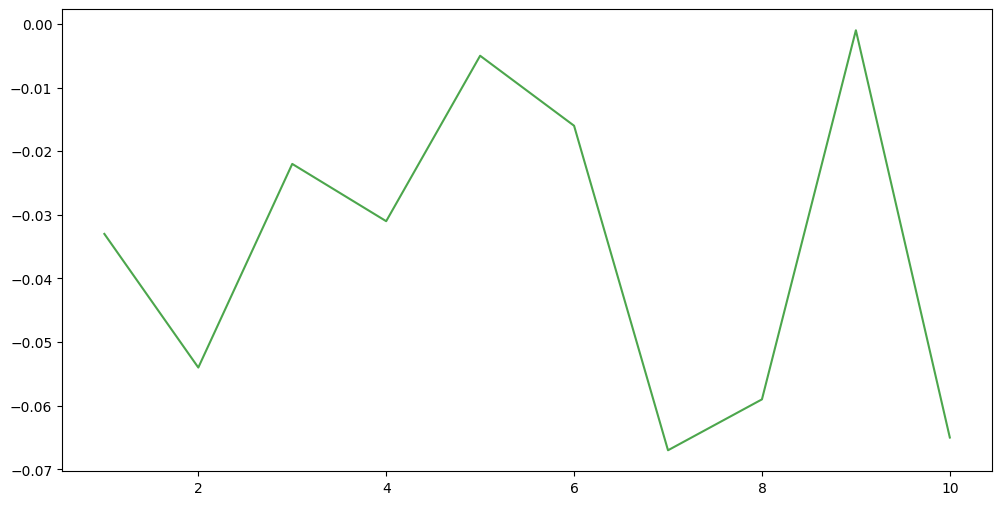

In [22]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, ITERS + 1), rnd_avg_rewards, label='Random Agent', color='red', alpha=0.7)
plt.plot(range(1, ITERS + 1), baseline_avg_rewards, label='Baseline Agent', color='blue', alpha=0.7)
plt.plot(range(1, ITERS + 1), dqn_avg_rewards, label='DQN Agent', color='green', alpha=0.7)

# Add a trend line for each agent
z_rnd = np.polyfit(range(1, ITERS + 1), rnd_avg_rewards, 1)
p_rnd = np.poly1d(z_rnd)
plt.plot(range(1, ITERS + 1), p_rnd(range(1, ITERS + 1)), "r--", alpha=0.5)

z_base = np.polyfit(range(1, ITERS + 1), baseline_avg_rewards, 1)
p_base = np.poly1d(z_base)
plt.plot(range(1, ITERS + 1), p_base(range(1, ITERS + 1)), "b--", alpha=0.5)

z_dqn = np.polyfit(range(1, ITERS + 1), dqn_avg_rewards, 1)
p_dqn = np.poly1d(z_dqn)
plt.plot(range(1, ITERS + 1), p_dqn(range(1, ITERS + 1)), "g--", alpha=0.5)

# Customize the plot
plt.title('Average Rewards per Iteration: all agents', fontsize=16)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Average Reward', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Add text with overall average rewards
plt.text(0.02, 0.98, f"Random Agent Overall Avg: {np.mean(rnd_avg_rewards):.4f}", 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.02, 0.94, f"Baseline Agent Overall Avg: {np.mean(baseline_avg_rewards):.4f}", 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.02, 0.90, f"DQN Agent Overall Avg: {np.mean(dqn_avg_rewards):.4f}", 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

# Show the plot
plt.tight_layout()
plt.show()

## Model

In [ ]:
# define the models that you need ()
agent = ...
value = ...
q = ...

## Training

In [34]:
optimizer = tf.keras.optimizers.legacy.Adam(1e-4)

In [ ]:
for iteration in trange(ITERATIONS):
    # get current state of the boards
    state = env_.to_state()
    with tf.GradientTape(persistent=True) as tape:
        """ 
        tensor of actions, consider that
            UP = 0
            RIGHT = 1
            DOWN = 2
            LEFT = 3
        """
        actions = ... 
        rewards = env_.move(actions)
        new_state = tf.constant(env_.to_state())

        # calculate the loss of whichever algorithm you have picked
        loss = ...

    gradient = tape.gradient(..., ...)
    optimizer.apply_gradients(zip(gradient, ...))

 ### Random policy reward
 
Just a baseline (not the one you are supposed to develop)

In [10]:
random_env = get_env(100)
random_rewards = []

for _ in trange(1000):
    probs = tf.convert_to_tensor([[.25]*4]*random_env.n_boards)
    #sample actions
    actions =  tf.random.categorical(tf.math.log(probs), 1, dtype=tf.int32)
    print(actions.shape)
    # MDP update
    rewards = random_env.move(actions)
    random_rewards.append(np.mean(rewards))

  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 1)
